## Proyecto 2 - Ciencia de datos

Integrentes: 

- Karina Valladares, 18005 

- Alexa Bravo, 18831

- José Eduardo López, 181045

In [52]:
#Importamos las Librerias a utilizar 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neattext as nt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import textdistance
import re
from collections import Counter
from sklearn.cluster import AgglomerativeClustering  

In [2]:
# leemos la data
data = pd.read_csv("train.csv")

data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
# revisamos cuántos NA hay
data.isna().sum().to_frame()

,0
id,0
keyword,61
location,2533
text,0
target,0


A partir del resumen anterior, es importante señalar que la cantidad de datos faltantes es sustancial para "location", por lo que esto necesitará un tratamiento especial.

### Variables

- **id**: hace referencia a un número único para cada registro, es de tipo numérico (no necesita limpieza). 
    Tenemos 0 datos faltantes. 
- **Keyword**: es una palabra que caracteriza al tweet, no todos los tweets lo tienen pero no escencial para el análisis de texto, aunque puede resultar de gran ayuda para aquellos tweets que si estén vinculados a una. Es de tipo String y solo necesitamos remover los signos de puntuación y pasar todo a mayúsuculas. Tenemos 61 datos faltantes. 
- **Location**: hace referencia al país desde el que se publicó el tweet, no todos los registros tienen esta variables pero puede ser de utilidad para los que si la tienen. Para la limpieza solo es necesario estandarizar los nombres y colocar todo en mayúsculas. Tenemos 2,533 datos faltantes.
- **text**: es el mensaje de texto adjunto al tweet, esta es la variable más importante y la quiere mayor limpieza. Como es una variable que contiene texto es necesaria procesar como lenguaje natural, quitar caracteres especiales, correos, números de teléfono, stopwrods, signos de puntuación, pasar todo a mayúsculas, remover URL, entre otros. Tenemos 0 datos faltantes
- **target**: es una variable binaria que clasifica si el tweet es sobre un desastre real: 1, 0 en caso contrario, no requiere limpieza. Tenemos 0 datos faltantes.

### Análisis Exploratorio

#### WordClouds

##### Keyword

In [4]:
# convertimos todo a un string
final_string = ""
for i in data["keyword"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

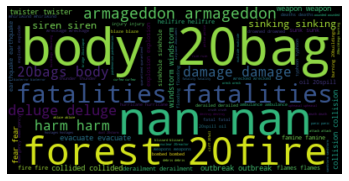

In [5]:
#WordCloud "keyword"
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

##### Location 

In [6]:
# convertimos todo a un string
final_string = ""
for i in data["location"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

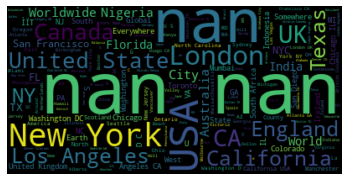

In [7]:
#WordCloud "location"
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

##### Text

In [8]:
# convertimos todo a un string
final_string = ""
for i in data["text"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

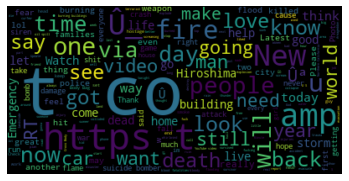

In [9]:
#WordCloud "text"
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### Target

In [10]:
pie = data.groupby("target").count()

<AxesSubplot:ylabel='id'>

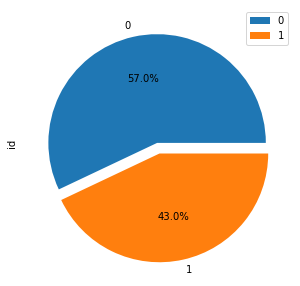

In [11]:
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

Podemos observar que un poco mas de la mitad de tweets no son sobre un desastre real. 

### Funciones

In [12]:
#Función para convertir todo a Mayúsculas 
def convertir_mayus(X):
    
    return X.str.upper()

#Función para remover stopwords, emails, números, números de telefono, url's, emojis, tags, caracteres especiales, signos de puntuación, ets. 
def limpiar(X):
    for i in range(len(X)):
        X[i] = nt.TextFrame(str(X[i])).remove_stopwords(lang = "en")
        X[i] = nt.TextFrame(str(X[i])).remove_emails()
        X[i] = nt.TextFrame(str(X[i])).remove_numbers()
        X[i] = nt.TextFrame(str(X[i])).remove_phone_numbers()
        X[i] = nt.TextFrame(str(X[i])).remove_btc_address()
        X[i] = nt.TextFrame(str(X[i])).remove_urls()
        X[i] = nt.TextFrame(str(X[i])).remove_emojis()
        X[i] = nt.TextFrame(str(X[i])).remove_html_tags()
        X[i] = nt.TextFrame(str(X[i])).remove_puncts()
        X[i] = nt.TextFrame(str(X[i])).remove_special_characters()
        X[i] = nt.TextFrame(str(X[i])).remove_stopwords(lang = "es")
    
    return X

#Funcion para normalizar los textos 
def normalizar(text):
    return re.sub('[^a-z0-9]+', ' ', text.lower())

def preNormText(texts, threshold=0.4): 
    
    normTexts = np.array([normalizar(text) for text in texts])
    distancia = 1 - np.array([[textdistance.jaro_winkler(one, another) for one in normTexts] for another in normTexts])
    clustering = AgglomerativeClustering(distance_threshold=threshold,affinity="precomputed", linkage="complete", n_clusters=None).fit(distancia)
    center = dict()
    for clusterId in set(clustering.labels_):
        index = clustering.labels_ == clusterId
        central = distancia[:, index][index].sum(axis=1)
        center[clusterId] = normTexts[index][central.argmin()]
    return [center[i] for i in clustering.labels_]

In [13]:
#Funcion para limpiar NA
def limpiar_na(X):
    resultado = []
    for i in range(len(X)):
        if str(X[i]) == "NAN":
            resultado.append("NO DATA")
        else:
            resultado.append(X[i])
    return resultado


### Limplieza de Datos

#### Keyword

In [14]:
keyword = data["keyword"]

##### Pasamos todo a mayúsculas

In [15]:
keyword = convertir_mayus(keyword)

##### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [16]:
keyword = limpiar(keyword)

In [17]:
data["keyword"] = keyword.astype(str)

In [18]:
data.groupby("keyword").count()

,id,location,text,target
keyword,,,,
ABLAZE,36,29,36,36
ACCIDENT,35,28,35,35
AFTERSHOCK,34,25,34,34
AIRPLANEACCIDENT,35,29,35,35
AMBULANCE,38,26,38,38
...,...,...,...,...
WOUNDS,33,27,33,33
WRECK,37,27,37,37
WRECKAGE,39,28,39,39


##### Normalización 

In [19]:
keyword = data["keyword"]

In [20]:
objetivo = preNormText(keyword, 0.6)

In [21]:
# sobreescribimos la columna en el dataframe
data["keyword"] = objetivo

In [22]:
# convertimos el texto a mayúsculas
data["keyword"] = data["keyword"].str.upper()

##### Limpieza de NA

In [23]:
# extraemos en una variable para trabajar sobre ella
Y = data["keyword"]

In [24]:
# limpiamos los na
Y = limpiar_na(Y)

In [25]:
# reemplazamos los espacios por "_"
for i in range(len(Y)):
    word = Y[i]
    new = word.replace(" ", "_")
    Y[i] = new

In [26]:
# sobreescribimos en el dataframe
data["keyword"] = Y

In [27]:
# agrupamos según la ubicación, para ver el resultado y sus cambios
data.groupby("keyword").count()

,id,location,text,target
keyword,,,,
ARSONIST,292,161,292,292
BOMBING,549,367,549,549
COLLAPSE,256,197,256,256
CRASHED,381,247,381,381
DEATH,451,314,451,451
DEMOLISHED,439,297,439,439
DROWN,245,168,245,245
ELECTROCUTE,243,155,243,243
EMERGENCY,281,194,281,281


#### Location

In [28]:
location = data["location"]

##### Pasamos todo a mayúsculas

In [29]:
location = convertir_mayus(location)

##### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [30]:
location = limpiar(location)

In [31]:
data["location"] = location.astype(str)

In [32]:
data.groupby("location").count()

,id,keyword,text,target
location,,,,
,302,302,302,302
A PROPERTY UNIVERSE,1,1,1,1
AARHUS CENTRAL JUTLAND,1,1,1,1
AAS AZTEC PRINCESS,1,1,1,1
AB CANADA,1,1,1,1
...,...,...,...,...
ZERO BRANCO,1,1,1,1
ZIAM AF,1,1,1,1
ZIMBABWE,1,1,1,1


##### Normalización

In [33]:
location = data["location"]

In [34]:
# limpiamos con la función definida
resultado = preNormText(location, 0.6)

In [35]:
# sobreescribimos la columna en el dataframe
data["location"] = resultado

In [36]:
# convertimos el texto a mayúsculas
data["location"] = data["location"].str.upper()

##### Limpieza de NA

In [37]:
# extraemos en una variable para trabajar sobre ella
X = data["location"]

In [38]:
# limpiamos los na
X = limpiar_na(X)

In [39]:
# reemplazamos los espacios por "_"
for i in range(len(X)): 
    word = X[i]
    new = word.replace(" ", "_")
    X[i] = new

In [40]:
# sobreescribimos en el dataframe
data["location"] = X

In [41]:
# agrupamos según la ubicación, para ver el resultado y sus cambios
data.groupby("location").count()

,id,keyword,text,target
location,,,,
,302,302,302,302
AIRES_ARGENTINA,32,32,32,32
ALBERTA,56,56,56,56
AMERICA,20,20,20,20
AMERICAN_WASTELAND_MV,20,20,20,20
...,...,...,...,...
WELLINGTON,19,19,19,19
WEST_COAST,23,23,23,23
WILLIAMSBURG,9,9,9,9


#### Text

In [42]:
text = data["text"]

##### Pasamos todo a mayúsculas

In [43]:
text = convertir_mayus(text)

##### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [44]:
text = limpiar(text)

In [45]:
data["text"] = text.astype(str)

In [46]:
data.groupby("text").count()

,id,keyword,location,target
text,,,,
A NIGHTMARE ELM STREET GETTING REMADE,1,1,1,1
A RADAR UPDATE WIDESPREAD SHOWERSSTORMS MOVING AREASMINOR FLOODING POSSIBLE HUNWX,1,1,1,1
A SLAMMING DOOR LESSON LEARNED LET LOVER CRASH BURN,1,1,1,1
A STARTED WRITING TALK TRAUMA THERAPY WAY COMMUNICATE GRAVITYCHAT,1,1,1,1
A VOLUNTARY EVACUATION RECOMMENDED TIME PICKEREL LAKE CABINS HIGHWAY REIDLAKE FIRE SAYS MACA NWT YZF,1,1,1,1
...,...,...,...,...
ZOUMA ABSOLUTELY FLATTENED GUY,1,1,1,1
ZOUMA FLATTENED CFC,1,1,1,1
ZOUMA FLATTENED GUY,1,1,1,1


### Análisis exploratorio de los datos más limpios

#### WordClouds

In [47]:
kwText = " ".join(review for review in data.keyword.astype(str))

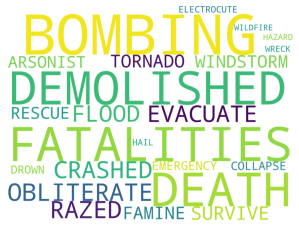

In [48]:
wordcloud = WordCloud(background_color="white", width=4200, height=3200,collocations = False,
                          stopwords=STOPWORDS).generate(kwText)
plt.axis("off")
plt.imshow(wordcloud)

In [49]:
# convertimos todo a un string
lText = " ".join(review for review in data.location.astype(str))

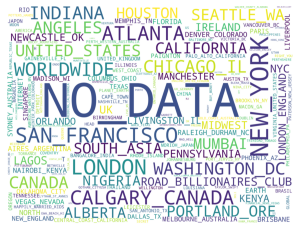

In [50]:
wordcloud = WordCloud(background_color="white", width=4200, height=3200,collocations = False,
                          stopwords=STOPWORDS).generate(lText)
plt.axis("off")
plt.imshow(wordcloud)

#### Frecuencia de Palabras

##### Keyword

In [79]:
kwFrequencies = Counter(kwText.split())

In [80]:
kwFrequencies

Counter({'ARSONIST': 292,
         'RAZED': 385,
         'FAMINE': 332,
         'EMERGENCY': 281,
         'ELECTROCUTE': 243,
         'DEMOLISHED': 439,
         'FATALITIES': 464,
         'OBLITERATE': 395,
         'BOMBING': 549,
         'HAIL': 240,
         'HAZARD': 213,
         'FLOOD': 359,
         'WILDFIRE': 198,
         'CRASHED': 381,
         'COLLAPSE': 256,
         'DEATH': 451,
         'RESCUE': 294,
         'TORNADO': 344,
         'DROWN': 245,
         'WINDSTORM': 327,
         'EVACUATE': 363,
         'WRECK': 215,
         'SURVIVE': 347})

In [81]:
palabras = []
frecuencias = []
for i in kwFrequencies.keys():
    palabras.append(i)

for k in kwFrequencies.values():
    frecuencias.append(k)

In [82]:
index1 = frecuencias.index(max(frecuencias))
pa1 = palabras[index1]
frecuencias.pop(index1)

index2 = frecuencias.index(max(frecuencias))
pa2 = palabras[index2]
frecuencias.pop(index2)

index3 = frecuencias.index(max(frecuencias))
pa3 = palabras[index3]
frecuencias.pop(index3)

print("La palabra más frecuente es: ", pa1)
print("La segunda palabra más frecuente es:", pa2)
print("La tercera palabra más frecuente es:", pa3)

La palabra más frecuente es:  BOMBING
La segunda palabra más frecuente es: FATALITIES
La tercera palabra más frecuente es: CRASHED


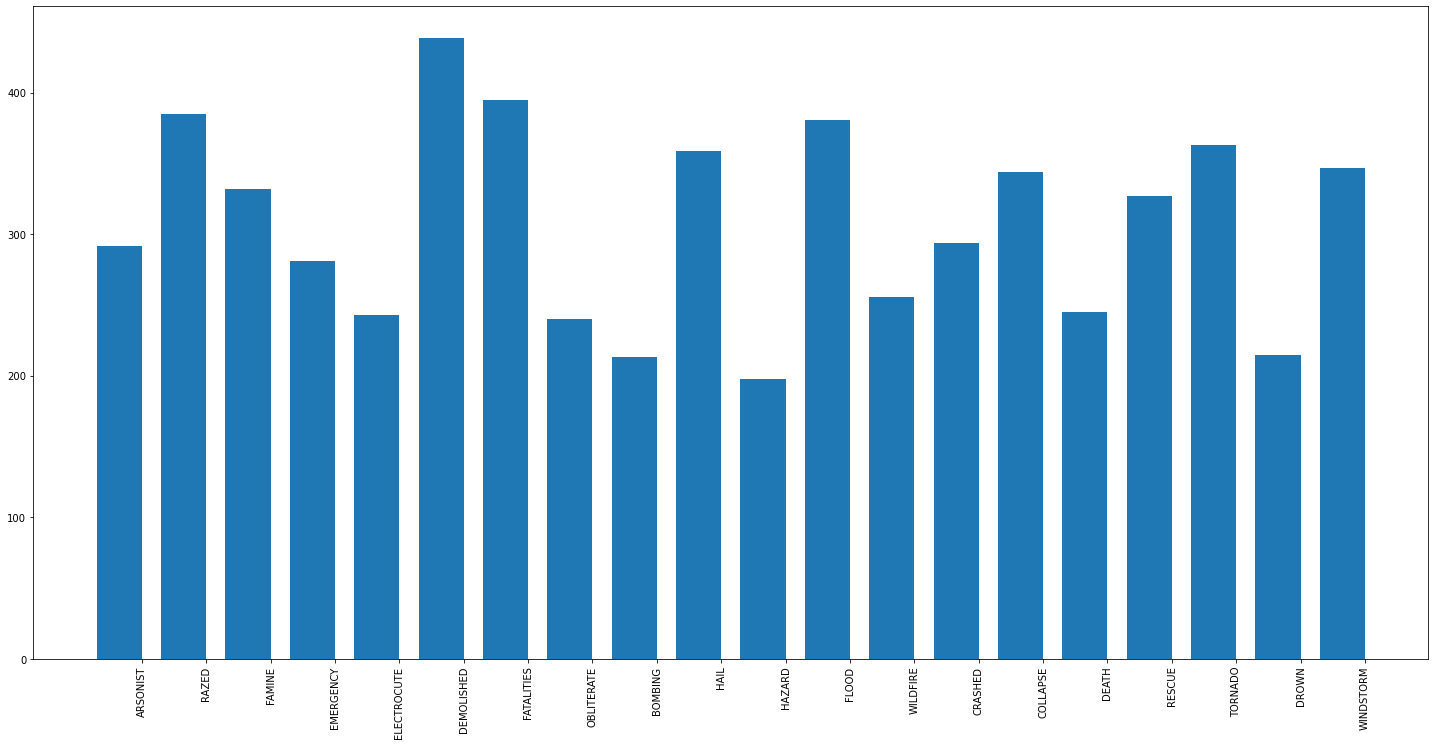

In [87]:
n = 20
words = palabras[0:n]
freq = frecuencias[0:n]

# Plot histogram using matplotlib bar().
indexes = np.arange(len(words))
width = 0.7

fig = plt.figure(figsize = (25, 12 ))
plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, words)
plt.xticks(rotation = 90)
plt.show()

##### Location

In [73]:
lFrequencies = Counter(lText.split())

In [74]:
lFrequencies

Counter({'NO_DATA': 2548,
         'BIRMINGHAM': 23,
         'HERE': 32,
         'AMERICA': 20,
         'PHILADELPHIA_PA': 22,
         'LONDON': 115,
         'RHODE_ISLAND': 22,
         'WORLDWIDE': 89,
         'ALBERTA': 56,
         'LIVE_MS': 13,
         'MIDWEST': 42,
         'OREGON': 25,
         'ANGELES': 70,
         'GAINESVILLE_FL': 25,
         'INDIANA': 82,
         'CANADA': 70,
         'SOUTH_ASIA': 56,
         'COLUMBUS_OHIO': 28,
         'H': 20,
         'TRINIDAD_TOBAGO': 16,
         'CALGARY_CANADA': 98,
         'TWITTER': 6,
         'CAPE_TOWN': 25,
         'SAN_FRANCISCO': 112,
         'IRELAND': 41,
         'NASHVILLE_TN': 20,
         'UK': 42,
         'WALKER_COUNTY_ALABAMA': 11,
         'PORTLAND_ORE': 59,
         'SAN_ANTONIO_TX': 21,
         'BROOKLYN_NY': 23,
         'LIVERPOOL': 30,
         'LIVINGSTON_IL': 33,
         'NEW_YORK': 170,
         'LOUISIANA': 19,
         'MANCHESTER': 32,
         'WELLINGTON': 19,
         'GLOBAL

In [76]:
palabras = []
frecuencias = []
for i in lFrequencies.keys():
    palabras.append(i)

for k in lFrequencies.values():
    frecuencias.append(k)

In [77]:
index1 = frecuencias.index(max(frecuencias))
pa1 = palabras[index1]
frecuencias.pop(index1)

index2 = frecuencias.index(max(frecuencias))
pa2 = palabras[index2]
frecuencias.pop(index2)

index3 = frecuencias.index(max(frecuencias))
pa3 = palabras[index3]
frecuencias.pop(index3)

print("La palabra más frecuente es: ", pa1)
print("La segunda palabra más frecuente es:", pa2)
print("La tercera palabra más frecuente es:", pa3)

La palabra más frecuente es:  NO_DATA
La segunda palabra más frecuente es: LIVINGSTON_IL
La tercera palabra más frecuente es: PHILADELPHIA_PA


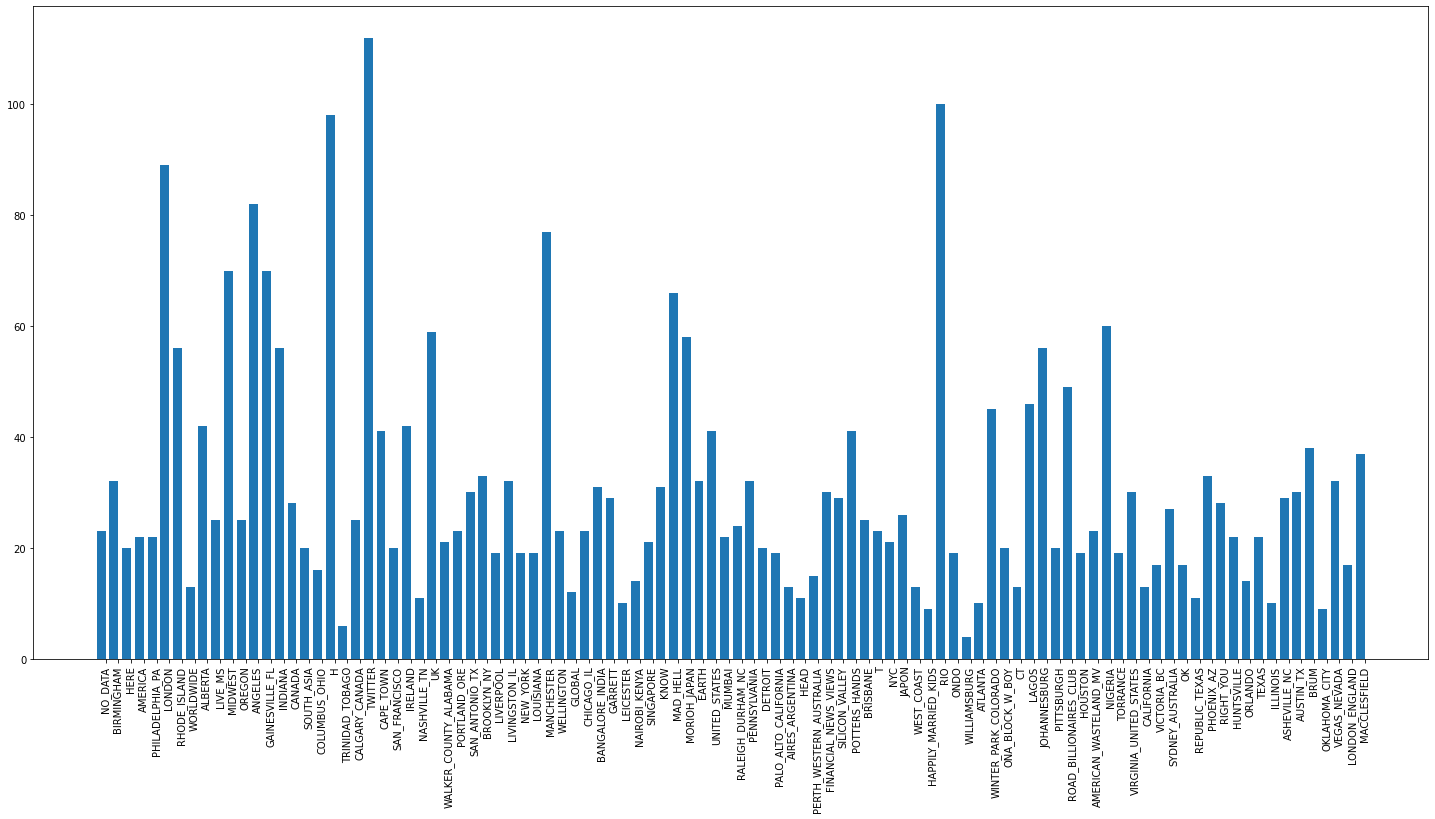

In [78]:
n = 100
words = palabras[0:n]
freq = frecuencias[0:n]

# Plot histogram using matplotlib bar().
indexes = np.arange(len(words))
width = 0.7

fig = plt.figure(figsize = (25, 12 ))
plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, words)
plt.xticks(rotation = 90)
plt.show()

##### Text

In [88]:
# convertimos todo a un string
Text = " ".join(review for review in data.text.astype(str))

In [91]:
Frequencies = Counter(Text.split())

In [92]:
Frequencies

Counter({'DEEDS': 2,
         'REASON': 20,
         'EARTHQUAKE': 50,
         'ALLAH': 9,
         'FORGIVE': 2,
         'FOREST': 65,
         'FIRE': 252,
         'NEAR': 54,
         'RONGE': 1,
         'SASK': 1,
         'CANADA': 11,
         'RESIDENTS': 8,
         'ASKED': 9,
         'SHELTER': 6,
         'PLACE': 26,
         'NOTIFIED': 1,
         'OFFICERS': 8,
         'EVACUATION': 50,
         'ORDERS': 11,
         'EXPECTED': 15,
         'PEOPLE': 196,
         'RECEIVE': 2,
         'WILDFIRES': 11,
         'CALIFORNIA': 117,
         'GOT': 112,
         'SENT': 13,
         'PHOTO': 41,
         'RUBY': 1,
         'ALASKA': 6,
         'SMOKE': 48,
         'POURS': 1,
         'SCHOOL': 66,
         'ROCKYFIRE': 4,
         'UPDATE': 37,
         'HWY': 10,
         'CLOSED': 20,
         'DIRECTIONS': 1,
         'LAKE': 14,
         'COUNTY': 38,
         'CAFIRE': 2,
         'FLOOD': 56,
         'DISASTER': 153,
         'HEAVY': 20,
         'RAIN'

In [93]:
palabras = []
frecuencias = []
for i in Frequencies.keys():
    palabras.append(i)

for k in Frequencies.values():
    frecuencias.append(k)

In [94]:
index1 = frecuencias.index(max(frecuencias))
pa1 = palabras[index1]
frecuencias.pop(index1)

index2 = frecuencias.index(max(frecuencias))
pa2 = palabras[index2]
frecuencias.pop(index2)

index3 = frecuencias.index(max(frecuencias))
pa3 = palabras[index3]
frecuencias.pop(index3)

print("La palabra más frecuente es: ", pa1)
print("La segunda palabra más frecuente es:", pa2)
print("La tercera palabra más frecuente es:", pa3)

La palabra más frecuente es:  LIKE
La segunda palabra más frecuente es: IM
La tercera palabra más frecuente es: PUBLICATIONS


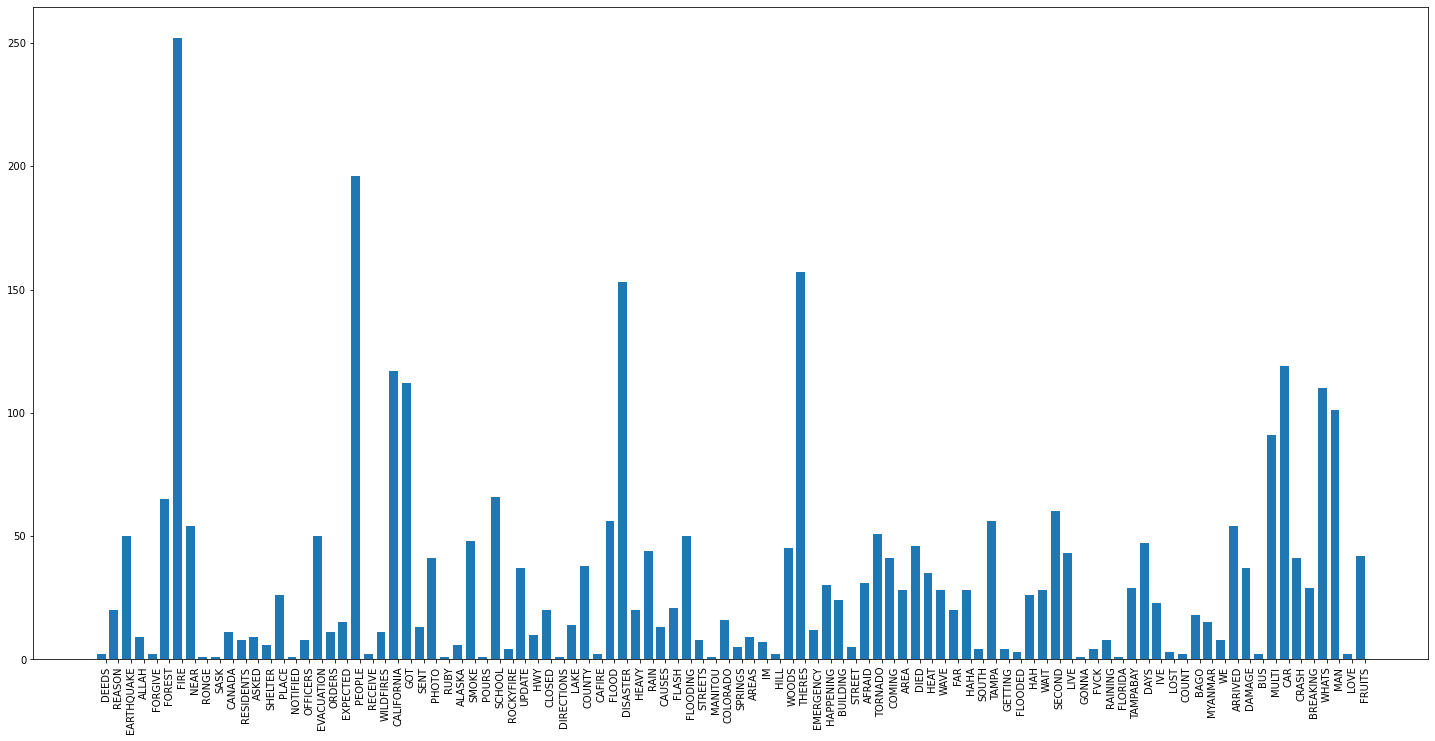

In [95]:
n = 100
words = palabras[0:n]
freq = frecuencias[0:n]

# Plot histogram using matplotlib bar().
indexes = np.arange(len(words))
width = 0.7

fig = plt.figure(figsize = (25, 12 ))
plt.bar(indexes, freq, width)
plt.xticks(indexes + width * 0.5, words)
plt.xticks(rotation = 90)
plt.show()